In [1]:
import nltk
from nltk.corpus import cess_esp
from nltk.tag import hmm, tnt
from random import shuffle
from math import sqrt
import matplotlib.pyplot as plt

In [2]:
corpus_sentences = cess_esp.tagged_sents()
number_sentences = len(corpus_sentences)

## 1. Process cess_esp

In [3]:
corpus = []

for sentece in corpus_sentences:
    new_sentence = []

    for word, label in sentece:
        if word != '*0*':
            if str.startswith(label, 'v') or str.startswith(label, 'F'):
                label = label[:3]
            else:
                label = label[:2]

            new_sentence.append((word, label))
    
    corpus.append(new_sentence)

In [4]:
train_sent_len = int(number_sentences*0.9)

train_sent = corpus[:train_sent_len]
test_sent = corpus[train_sent_len:]

## 2.1 HMM

In [5]:
tagger_hmm = hmm.HiddenMarkovModelTagger.train(train_sent)

In [6]:
words = [word for word, label in test_sent[0]]
print(words)
pred = tagger_hmm.tag(words)
for word, label in pred:
    print("{} | {}".format(word, label))

['Y', 'al_final', 'le', 'pedía', 'que', 'colabore', 'conmigo', 'en', 'la', 'campaña', 'electoral', 'vasca', '-', '.']
Y | cc
al_final | rg
le | pp
pedía | vmi
que | cs
colabore | vai
conmigo | vmp
en | sp
la | da
campaña | nc
electoral | aq
vasca | aq
- | Fg
. | Fp


In [7]:
tagger_hmm.evaluate(test_sent)

0.8784427571832664

## 2.2 TNT

In [8]:
tagger_TNT = tnt.TnT()
tagger_TNT.train(train_sent)

In [9]:
words = [word for word, label in test_sent[0]]
print(words)
pred = tagger_TNT.tag(words)
for word, label in pred:
    print("{} | {}".format(word, label))

['Y', 'al_final', 'le', 'pedía', 'que', 'colabore', 'conmigo', 'en', 'la', 'campaña', 'electoral', 'vasca', '-', '.']
Y | cc
al_final | rg
le | pp
pedía | vmi
que | cs
colabore | Unk
conmigo | Unk
en | sp
la | da
campaña | nc
electoral | aq
vasca | aq
- | Fg
. | Fp


In [10]:
tagger_TNT.evaluate(test_sent)

0.8255173440524044

## 3. Cross-validation

In [11]:
tagger_hmm = hmm.HiddenMarkovModelTagger
acc_HMM_originalOrder = []
acc_HMM_shuffle = []

#tagger_TNT = tnt.TnT()
acc_TNT_originalOrder = []
acc_TNT_shuffle = []

k = 10
partitionSize = int(len(corpus)/k)
partitions = [corpus[i*partitionSize:(i*partitionSize)+partitionSize] for i in range(k)]

shuffled_corpus = corpus.copy()
shuffle(shuffled_corpus)
partitions_shuffled = [shuffled_corpus[i*partitionSize:(i*partitionSize)+partitionSize] for i in range(k)]

###  Original order

In [12]:
for i in range(k):
    test = partitions[i]
    train = partitions[:i] + partitions[i+1:]
    train = [val for sublist in train for val in sublist]
    
    tagger_hmm = tagger_hmm.train(train[0:-1])
    acc_HMM_originalOrder.append(tagger_hmm.evaluate(test))
    
    tagger_TNT = tnt.TnT()
    tagger = tagger_TNT.train(train[0:-1])
    acc_TNT_originalOrder.append(tagger_TNT.evaluate(test))

In [13]:
acc_HMM_originalOrder

[0.9284063638787663,
 0.9238470598894627,
 0.9228301472203911,
 0.9251021133013674,
 0.9228631913204551,
 0.8781806196440343,
 0.8878207393793737,
 0.8914285714285715,
 0.8912859560067682,
 0.8784427571832664]

In [14]:
acc_TNT_originalOrder

[0.8963203270820371,
 0.8886019751744133,
 0.8865304328718963,
 0.889540046172971,
 0.8927846873070477,
 0.838892551087673,
 0.8582738389764615,
 0.850780559646539,
 0.8591370558375635,
 0.8255173440524044]

### Shuffled

In [15]:
for i in range(k):
    test = partitions_shuffled[i]
    train = partitions_shuffled[:i] + partitions_shuffled[i+1:]
    train = [val for sublist in train for val in sublist]
    
    tagger_hmm = tagger_hmm.train(train[0:-1])
    acc_HMM_shuffle.append(tagger_hmm.evaluate(test))
    
    tagger_TNT = tnt.TnT()
    tagger = tagger_TNT.train(train[0:-1])
    acc_TNT_shuffle.append(tagger_TNT.evaluate(test))

In [16]:
acc_HMM_shuffle

[0.9259748843357568,
 0.9248806806391368,
 0.925578685311722,
 0.9245889142981596,
 0.9263062679578589,
 0.9260170689564898,
 0.9250297715708563,
 0.9278190664599262,
 0.9263567931778702,
 0.9253208238973364]

In [17]:
acc_TNT_shuffle

[0.9000457572830343,
 0.9018987341772152,
 0.9033847131733672,
 0.9020472612436023,
 0.9026284984569544,
 0.9016178857531808,
 0.8969362347082386,
 0.9032775490563011,
 0.905142917302732,
 0.9019195513857435]

## 4. Results

In [18]:
def sSquared(values):
    m = sum(values) / len(values)
    squared = sum([(v - m)**2 for v in values]) / len(values)
    leftInterval = s
    return "[{:.4f}, {:.4f}]".format(m-squared, m+squared)

In [19]:
def accuracy95(p, ndatos):
    return 1.95 * sqrt(p*(1-p)/ndatos)

Cross validation HMM:		[0.9046, 0.9054]
Cross validation HMM:		[0.9258, 0.9258]
Cross validation TNT shuffled:	[0.8681, 0.8692]
Cross validation TNT shuffled:	[0.9019, 0.9019]


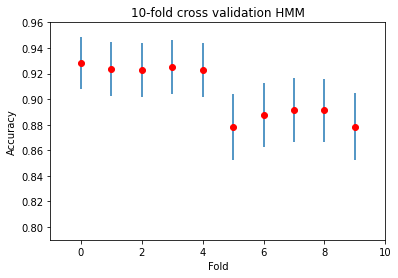

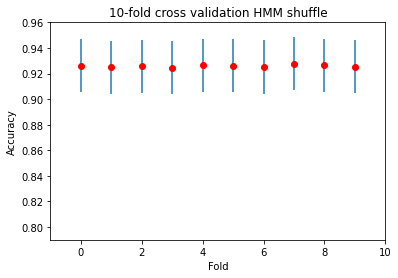

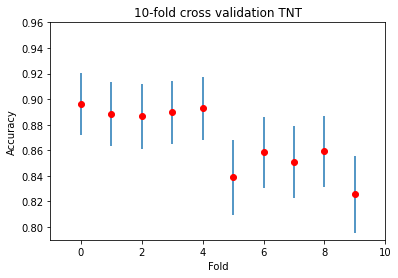

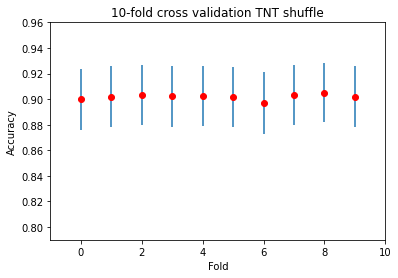

In [20]:
print("Cross validation HMM:\t\t{}".format(sSquared(acc_HMM_originalOrder)))
print("Cross validation HMM:\t\t{}".format(sSquared(acc_HMM_shuffle)))
print("Cross validation TNT shuffled:\t{}".format(sSquared(acc_TNT_originalOrder)))
print("Cross validation TNT shuffled:\t{}".format(sSquared(acc_TNT_shuffle)))

x = [i for i in range(10)]
graphRange = [-1, 10, 0.75, 0.96]

plt.title('10-fold cross validation HMM')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.axis(graphRange)
y = acc_HMM_originalOrder
plt.plot(x, y,'or')
Tic=[accuracy95(p, len(corpus)//k) for p in y]# Lista con los intervalos de confianza
plt.errorbar(x, y, yerr=Tic, linestyle='None')
plt.show()

plt.title('10-fold cross validation HMM shuffle')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.axis(graphRange)
y = acc_HMM_shuffle
plt.plot(x, y,'or')
Tic=[accuracy95(p, len(corpus)//k) for p in y]# Lista con los intervalos de confianza
plt.errorbar(x, y, yerr=Tic, linestyle='None')
plt.show()

plt.title('10-fold cross validation TNT')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.axis(graphRange)
y = acc_TNT_originalOrder
plt.plot(x, y,'or')
Tic=[accuracy95(p, len(corpus)//k) for p in y]# Lista con los intervalos de confianza
plt.errorbar(x, y, yerr=Tic, linestyle='None')
plt.show()

plt.title('10-fold cross validation TNT shuffle')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.axis(graphRange)
y = acc_TNT_shuffle
plt.plot(x, y,'or')
Tic=[accuracy95(p, len(corpus)//k) for p in y]# Lista con los intervalos de confianza
plt.errorbar(x, y, yerr=Tic, linestyle='None')
plt.show()